In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd

mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
X, y = mnist.data, mnist.target

In [3]:
X.shape, y.shape

((70000, 784), (70000,))

In [4]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

(None, '5')

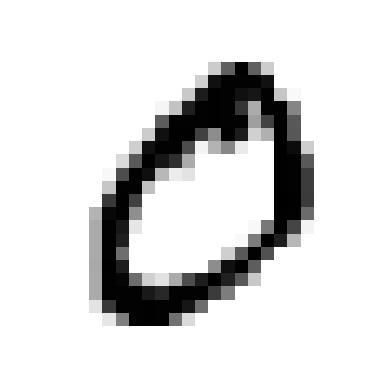

In [5]:
from matplotlib import pyplot as plt

def show_digit(digit):
    image = digit.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

show_digit(X[1]), y[0]

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
y_train_5, y_test_5 = (y_train == '5'), (y_test == '5')
y_test_5, y_train_5

(array([False, False, False, ..., False,  True, False]),
 array([ True, False, False, ...,  True, False, False]))

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(n_jobs=-1)
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(n_jobs=-1)

In [9]:
sgd_classifier.predict([X[1]])

array([False])

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_classifier, X_train, y_train_5, cv=5, n_jobs=-1, scoring="accuracy")

array([0.95183333, 0.97008333, 0.94833333, 0.96075   , 0.96566667])

In [11]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(X_train, y_train_5)

DummyClassifier(strategy='most_frequent')

In [12]:
# cross_val_score(dummy_classifier, X_train, y_train_5, scoring="accuracy", cv=3, n_jobs=-1)

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3) # add shuffle=True if the dataset is
#  # not already shuffled
# for train_index, test_index in skfolds.split(X_train, y_train_5):
#  clone_clf = clone(sgd_classifier)
#  X_train_folds = X_train[train_index]
#  y_train_folds = y_train_5[train_index]
#  X_test_fold = X_train[test_index]
#  y_test_fold = y_train_5[test_index]
#  clone_clf.fit(X_train_folds, y_train_folds)
#  y_pred = clone_clf.predict(X_test_fold)
#  n_correct = sum(y_pred == y_test_fold)
#  print(n_correct / len(y_pred)) # prints 0.95035, 0.96035, and 0.9604

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_train_5_cv_preds = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)

In [15]:
cf_matrix = confusion_matrix(y_train_5, y_train_5_cv_preds)
cf_matrix

array([[53279,  1300],
       [ 1370,  4051]])

In [16]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

In [17]:
from sklearn.metrics import recall_score, precision_score

recall = recall_score(y_train_5, y_train_5_cv_preds)
precission = precision_score(y_train_5, y_train_5_cv_preds)
recall, precission

(0.7472790997970854, 0.7570547561203513)

In [18]:
from sklearn.metrics import f1_score

f1 = f1_score(y_train_5, y_train_5_cv_preds)
f1

0.7521351652432232

In [19]:
y_scores = sgd_classifier.decision_function(X_train)
treshold = -3000

y_preds_5_treshold = (y_scores > treshold)

f1 = f1_score(y_train_5, y_preds_5_treshold)
precision = precision_score(y_train_5, y_preds_5_treshold)
recall = recall_score(y_train_5, y_preds_5_treshold)

print(f"f1: {f1} precission: {precision} recall: {recall}")

f1: 0.39111012662901024 precission: 0.24448444567525154 recall: 0.9771259915144808


In [20]:
# y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method="decision_function")

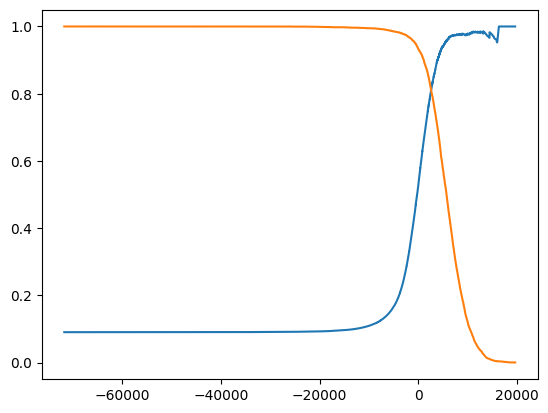

In [21]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, tresholds = precision_recall_curve(y_train_5, y_scores)

plt.plot(tresholds, precisions[:-1])
plt.plot(tresholds, recalls[:-1])

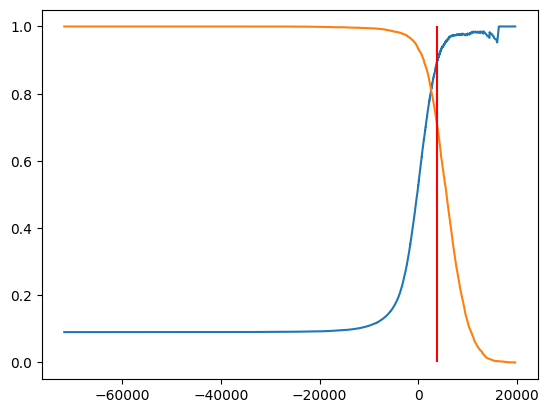

In [22]:
idx_for_90_precision = (precisions >= 0.9).argmax()
treshold_for_90_precision = tresholds[idx_for_90_precision]

plt.plot(tresholds, precisions[:-1])
plt.plot(tresholds, recalls[:-1])
plt.vlines(treshold_for_90_precision, 0, 1, "r")

In [23]:
y_train_5_preds = (y_scores >= treshold_for_90_precision)
precision_score(y_train_5, y_train_5_preds), recall_score(y_train_5, y_train_5_preds)

(0.9000474833808167, 0.6993174691016417)

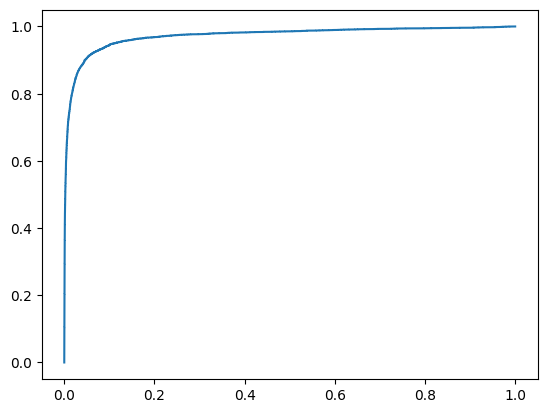

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, tresholds = roc_curve(y_train_5, y_scores)

plt.plot(fpr, tpr)

In [25]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9725497540650575

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probs_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, n_jobs=-1, method="predict_proba")

In [27]:
y_probs_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [28]:
y_scores_forest = y_probs_forest[:, [1]]
y_scores_forest

array([[0.89],
       [0.01],
       [0.04],
       ...,
       [0.98],
       [0.08],
       [0.06]])

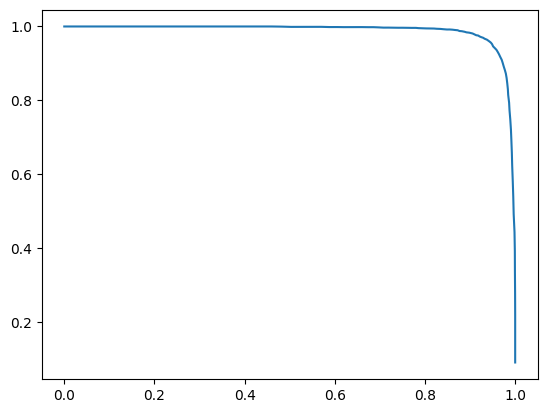

In [29]:
precission_forest, recall_forest, treshold_forest = precision_recall_curve(y_train_5, y_scores_forest)

plt.plot(recall_forest, precission_forest)


In [30]:
y_preds_forest = (y_scores_forest > 0.5)

f1_score(y_train_5, y_preds_forest), roc_auc_score(y_train_5, y_preds_forest)

(0.9242275142688448, 0.9327181722735077)

In [31]:
from sklearn.svm import SVC

svc_clf = SVC(random_state=42)
svc_clf.fit(X_train, y_train)

SVC(random_state=42)

In [32]:
label_idx = svc_clf.decision_function([X[0]]).round(2).argmax()
svc_clf.classes_[label_idx]

'5'

In [33]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42), n_jobs=-1)

ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42), n_jobs=-1)

In [34]:
sgd_clf = SGDClassifier(n_jobs=-1, random_state=42)

sgd_clf.fit(X_train, y_train)

SGDClassifier(n_jobs=-1, random_state=42)

In [35]:
sgd_clf.predict([X[0]])

array(['3'], dtype='<U1')

In [36]:
sgd_clf.decision_function([X[0]])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [37]:
cross_val_score(sgd_clf, X_train, y_train, cv=5, n_jobs=-1)

array([0.88083333, 0.88325   , 0.88116667, 0.86625   , 0.8875    ])

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
# cross_val_score(sgd_clf, X_train_scaled, y_train, cv=5, n_jobs=-1)

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=-1)

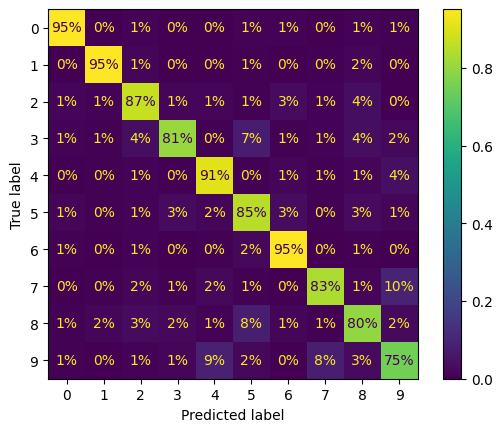

In [41]:
cf_matrix = confusion_matrix(y_train, y_train_pred)

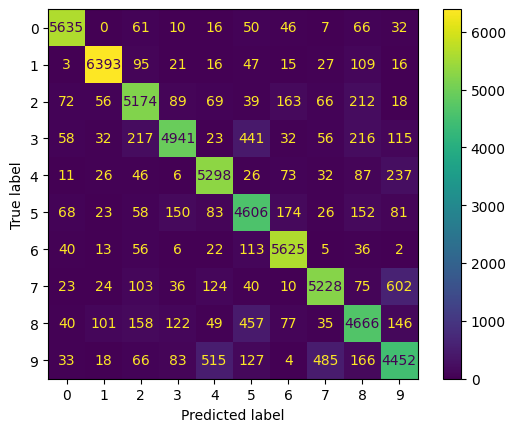

In [42]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

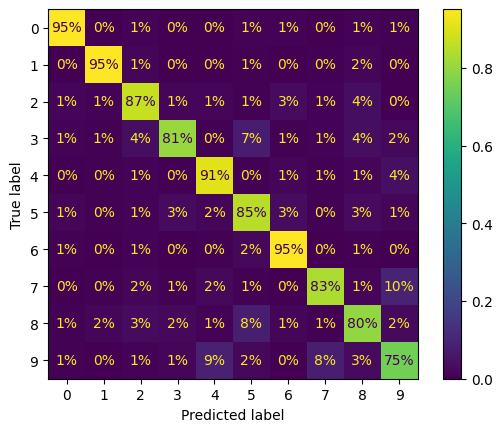

In [47]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")

In [51]:
sample_weight = (y_train_pred != y_train)
sample_weight

array([False, False, False, ..., False, False, False])

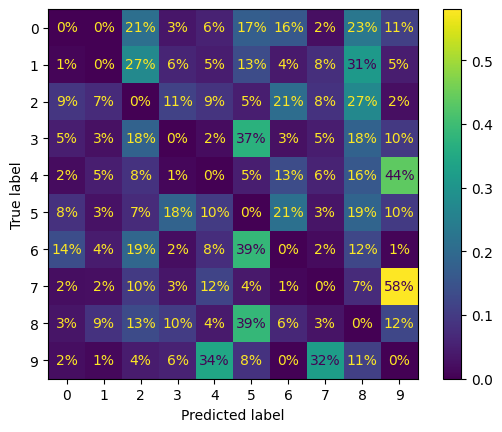

In [55]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", sample_weight=sample_weight, values_format=".0%")

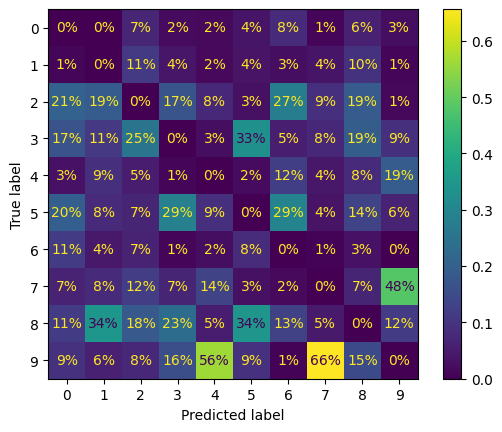

In [57]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="pred", sample_weight=sample_weight, values_format=".0%")

<Axes: >

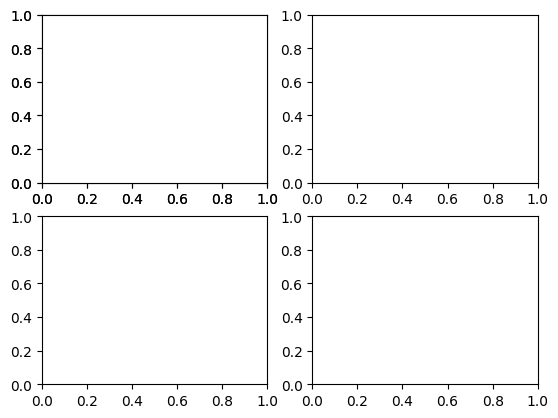

In [74]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

fig, axes = plt.subplots(2, 2)

fig.add_subplot(2,2,1)
    

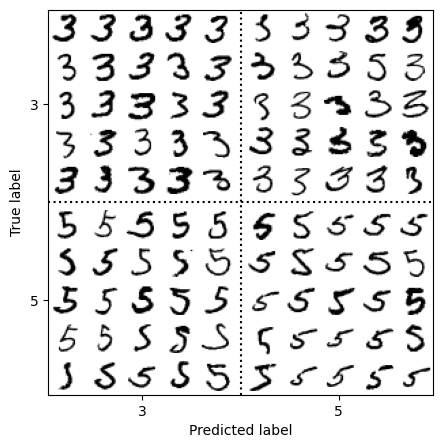

In [82]:
# extra code – this cell generates and saves Figure 3–11
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [91]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(n_jobs=-1)

In [93]:
knn_clf.predict([X_train[0]])

array([[False,  True]])

In [94]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, n_jobs=-1, cv=3)

In [95]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [98]:
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

In [99]:
from sklearn.multioutput import ClassifierChain
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [101]:
chain_clf.predict([X[0]])

array([[0., 1.]])

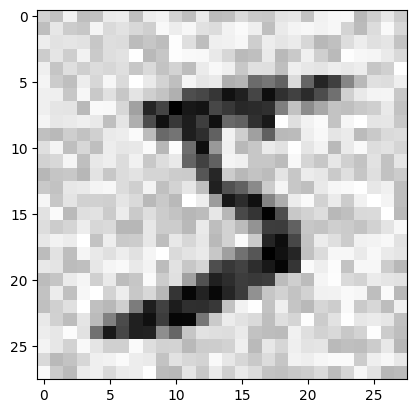

In [107]:
np.random_seed = 42
noise = np.random.randint(0, 100, (len(X_train), len(X_train[0])))
X_train_with_noise = X_train + noise
plt.imshow(X_train_with_noise[0].reshape(28,28), cmap="binary")

In [109]:
noise = np.random.randint(0, 100, (len(X_test), len(X_test[0])))
X_test_with_noise = X_test + noise

In [110]:
y_train_noise = X_train
y_test_noise = X_test

In [111]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_with_noise, y_train_noise)

KNeighborsClassifier()

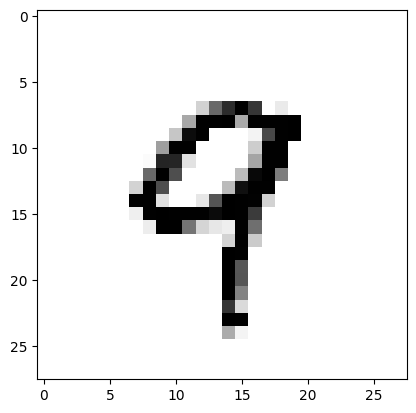

In [118]:
predicted = knn_clf.predict([X_train_with_noise[4]]).reshape(28,28)

plt.imshow(predicted, cmap="binary")